In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import os
import logging
import argparse
import glob
import json
from multiprocessing import Pool

from IPython.display import display, Markdown

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image

import pandas as pd
from astropy.table import Table  # for NSA
from astropy import units as u

from scipy import stats, integrate
from scipy.stats import binom
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, mean_squared_error, mean_absolute_error
import tensorflow as tf

from shared_astro_utils import astropy_utils, matching_utils
from zoobot.estimators import make_predictions, bayesian_estimator_funcs
from zoobot.tfrecord import read_tfrecord
from zoobot.uncertainty import discrete_coverage
from zoobot.estimators import input_utils, losses, dirichlet_stats
from zoobot.tfrecord import catalog_to_tfrecord
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline, run_estimator_config
from zoobot.active_learning import acquisition_utils
from zoobot import label_metadata


In [7]:
os.chdir('/home/walml/repos/zoobot')

In [8]:
questions = label_metadata.decals_questions
label_cols = label_metadata.decals_label_cols
version = 'decals'

schema = losses.Schema(label_cols, questions, version=version)
schema.questions

{smooth-or-featured, indices 0 to 2, asked after None: (0, 2), disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1: (3, 4), has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4: (5, 6), bar, indices 7 to 9, asked after disk-edge-on_no, index 4: (7, 9), bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4: (10, 14), how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0: (15, 17), edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3: (18, 20), spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5: (21, 23), spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5: (24, 29), merging, indices 30 to 33, asked after None: (30, 33)}


[smooth-or-featured, indices 0 to 2, asked after None,
 disk-edge-on, indices 3 to 4, asked after smooth-or-featured_featured-or-disk, index 1,
 has-spiral-arms, indices 5 to 6, asked after disk-edge-on_no, index 4,
 bar, indices 7 to 9, asked after disk-edge-on_no, index 4,
 bulge-size, indices 10 to 14, asked after disk-edge-on_no, index 4,
 how-rounded, indices 15 to 17, asked after smooth-or-featured_smooth, index 0,
 edge-on-bulge, indices 18 to 20, asked after disk-edge-on_yes, index 3,
 spiral-winding, indices 21 to 23, asked after has-spiral-arms_yes, index 5,
 spiral-arm-count, indices 24 to 29, asked after has-spiral-arms_yes, index 5,
 merging, indices 30 to 33, asked after None]

In [5]:
# several models (ensemble)
# copied from performance_metrics.ipynb
samples = []
predictions_locs = [f'results/decals_dr_train_labelled_m{n}_eval_predictions.csv' for n in range(5)]
# predictions_locs = ['folder_dr2_partial_model_decals_dr_train_labelled_m0_predictions.csv']

for predictions_loc in predictions_locs:
    predictions = pd.read_csv(predictions_loc)
    model_samples = dirichlet_stats.load_all_concentrations(predictions, concentration_cols=[a.text + '_concentration' for a in schema.answers])
    samples.append(model_samples)
samples = np.concatenate(samples, axis=2)

print(samples.shape)

(62503, 34, 5)


In [6]:
# TODO refactor this into release package
def apply_over_questions(concentrations, question_index_groups, func):
    results = []
    for q_n in range(len(question_index_groups)):
        q_indices = question_index_groups[q_n]
        q_start = q_indices[0]
        q_end = q_indices[1]
        q_result = func(concentrations[:, q_start:q_end+1])
        results.append(q_result)
    
    results = np.concatenate(results, axis=1)
    return results  # leave the reduce_sum to the estimator

def mean_for_answers(concentrations_for_q):
     return dirichlet_stats.DirichletEqualMixture(concentrations_for_q).mean()
    

In [7]:


mean_answers = apply_over_questions(samples, schema.question_index_groups, mean_for_answers)  # calculate the mean prediction for every question
# mean_answers = apply_over_questions(concentrations[:, :, :1], schema.question_index_groups, mean_for_answers)  # calculate the prediction for just the first model
mean_answers.shape  # shape of (galaxies, mean prediction for answer)

(62503, 34)

In [8]:
index = 2

In [9]:
for answer_n, answer in enumerate(schema.answers):
    print('{}: {:.2f}'.format(answer.text, mean_answers[index][answer_n]))

smooth-or-featured_smooth: 0.82
smooth-or-featured_featured-or-disk: 0.11
smooth-or-featured_artifact: 0.06
disk-edge-on_yes: 0.25
disk-edge-on_no: 0.75
has-spiral-arms_yes: 0.07
has-spiral-arms_no: 0.93
bar_strong: 0.03
bar_weak: 0.08
bar_no: 0.89
bulge-size_dominant: 0.04
bulge-size_large: 0.32
bulge-size_moderate: 0.51
bulge-size_small: 0.10
bulge-size_none: 0.04
how-rounded_round: 0.03
how-rounded_in-between: 0.91
how-rounded_cigar-shaped: 0.06
edge-on-bulge_boxy: 0.07
edge-on-bulge_none: 0.11
edge-on-bulge_rounded: 0.81
spiral-winding_tight: 0.46
spiral-winding_medium: 0.23
spiral-winding_loose: 0.31
spiral-arm-count_1: 0.03
spiral-arm-count_2: 0.54
spiral-arm-count_3: 0.03
spiral-arm-count_4: 0.03
spiral-arm-count_more-than-4: 0.05
spiral-arm-count_cant-tell: 0.32
merging_none: 0.87
merging_minor-disturbance: 0.10
merging_major-disturbance: 0.02
merging_merger: 0.01


In [14]:
predictions['iauname'] = predictions['png_path'].apply(lambda x: x.split('/')[-1].replace('.jpeg', ''))

In [19]:
predictions['png_path'][0]

'/data/phys-zooniverse/chri5177/galaxy_zoo/decals/dr1_dr2/png/decals-dr2/standard/J142005.40-013547.0.jpeg'

In [24]:
# predictions['local_png_loc'] = predictions['local_png_loc'].apply(lambda x: x.replace('/data/phys-zooniverse/chri5177', '/media/walml/beta/decals'))
predictions['local_png_loc'] = predictions['png_path'].apply(lambda x: x.replace('/data/phys-zooniverse/chri5177', '/media/walml/beta'))

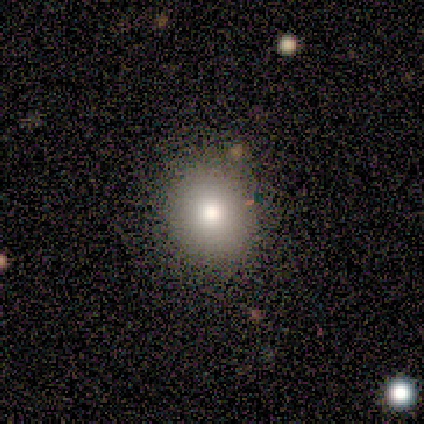

In [48]:
Image.open(predictions.iloc[9]['local_png_loc'])

In [44]:
df_p = pd.DataFrame(data=mean_answers, columns=[a + '_fraction' for a in schema.label_cols])
df_p = pd.concat([predictions[['iauname']], df_p], axis=1)

In [47]:
print('Hi {}'.format('Xueer'))

Hi Xueer


In [46]:
df_p

,iauname,smooth-or-featured_smooth_fraction,smooth-or-featured_featured-or-disk_fraction,smooth-or-featured_artifact_fraction,disk-edge-on_yes_fraction,disk-edge-on_no_fraction,has-spiral-arms_yes_fraction,has-spiral-arms_no_fraction,bar_strong_fraction,bar_weak_fraction,...,spiral-arm-count_1_fraction,spiral-arm-count_2_fraction,spiral-arm-count_3_fraction,spiral-arm-count_4_fraction,spiral-arm-count_more-than-4_fraction,spiral-arm-count_cant-tell_fraction,merging_none_fraction,merging_minor-disturbance_fraction,merging_major-disturbance_fraction,merging_merger_fraction
0,J142005.40-013547.0,0.906245,0.048457,0.045298,0.590174,0.409826,0.203283,0.796717,0.054567,0.147601,...,0.071642,0.207640,0.061387,0.031872,0.047455,0.580004,0.902274,0.074577,0.012377,0.010772
1,J151457.81+122739.0,0.675689,0.237603,0.086708,0.031678,0.968322,0.602730,0.397270,0.081785,0.422584,...,0.039671,0.456452,0.111491,0.043626,0.027244,0.321515,0.763418,0.199075,0.026532,0.010975
2,J153737.12+145716.4,0.823865,0.112850,0.063285,0.254945,0.745055,0.066862,0.933138,0.030486,0.075983,...,0.034023,0.538772,0.025784,0.033530,0.052349,0.315542,0.869761,0.102241,0.017677,0.010321
3,J121046.57-002508.7,0.251472,0.695982,0.052546,0.078874,0.921126,0.867245,0.132755,0.145904,0.392819,...,0.024675,0.763713,0.037216,0.015631,0.013567,0.145197,0.793056,0.164484,0.027254,0.015206
4,J153745.89+115248.2,0.434864,0.192920,0.372216,0.079619,0.920381,0.053514,0.946486,0.031272,0.055300,...,0.149229,0.221398,0.097322,0.035092,0.059520,0.437438,0.319837,0.061073,0.033321,0.585769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62498,J080205.52+175501.6,0.744023,0.117999,0.137978,0.222129,0.777871,0.049040,0.950960,0.056271,0.081928,...,0.102866,0.221673,0.069207,0.038081,0.084534,0.483638,0.385682,0.100998,0.037002,0.476318
62499,J145955.74+125830.5,0.792869,0.077593,0.129538,0.058041,0.941959,0.048366,0.951634,0.020199,0.035062,...,0.113396,0.219769,0.123463,0.104114,0.151985,0.287273,0.914040,0.060321,0.014866,0.010774
62500,J093855.98+215524.3,0.767966,0.114084,0.117950,0.116325,0.883675,0.029851,0.970149,0.039697,0.088774,...,0.101897,0.337191,0.108347,0.093811,0.084842,0.273911,0.838624,0.116107,0.028732,0.016538
62501,J102156.66+245459.8,0.802782,0.076646,0.120572,0.072562,0.927438,0.050653,0.949347,0.020479,0.041681,...,0.076320,0.180236,0.124237,0.101411,0.126995,0.390801,0.888284,0.084096,0.015679,0.011941


In [30]:
retirement = 1
for question in schema.questions:
    expected_votes = acquisition_utils.get_expected_votes_human(df_p, question, retirement, schema, round_votes=False)
    if isinstance(expected_votes, tf.Tensor):
        expected_votes = expected_votes.numpy()
    df_p[question.text + '_proportion_volunteers_asked'] = expected_votes

In [31]:
df_p

,iauname,smooth-or-featured_smooth_fraction,smooth-or-featured_featured-or-disk_fraction,smooth-or-featured_artifact_fraction,disk-edge-on_yes_fraction,disk-edge-on_no_fraction,has-spiral-arms_yes_fraction,has-spiral-arms_no_fraction,bar_strong_fraction,bar_weak_fraction,...,smooth-or-featured_proportion_volunteers_asked,disk-edge-on_proportion_volunteers_asked,has-spiral-arms_proportion_volunteers_asked,bar_proportion_volunteers_asked,bulge-size_proportion_volunteers_asked,how-rounded_proportion_volunteers_asked,edge-on-bulge_proportion_volunteers_asked,spiral-winding_proportion_volunteers_asked,spiral-arm-count_proportion_volunteers_asked,merging_proportion_volunteers_asked
0,J142005.40-013547.0,0.906245,0.048457,0.045298,0.590174,0.409826,0.203283,0.796717,0.054567,0.147601,...,1.0,0.048457,0.019859,0.019859,0.019859,0.906245,0.028598,0.004037,0.004037,1.0
1,J151457.81+122739.0,0.675689,0.237603,0.086708,0.031678,0.968322,0.602730,0.397270,0.081785,0.422584,...,1.0,0.237603,0.230076,0.230076,0.230076,0.675689,0.007527,0.138674,0.138674,1.0
2,J153737.12+145716.4,0.823865,0.112850,0.063285,0.254945,0.745055,0.066862,0.933138,0.030486,0.075983,...,1.0,0.112850,0.084079,0.084079,0.084079,0.823865,0.028771,0.005622,0.005622,1.0
3,J121046.57-002508.7,0.251472,0.695982,0.052546,0.078874,0.921126,0.867245,0.132755,0.145904,0.392819,...,1.0,0.695982,0.641087,0.641087,0.641087,0.251472,0.054895,0.555979,0.555979,1.0
4,J153745.89+115248.2,0.434864,0.192920,0.372216,0.079619,0.920381,0.053514,0.946486,0.031272,0.055300,...,1.0,0.192920,0.177560,0.177560,0.177560,0.434864,0.015360,0.009502,0.009502,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62498,J080205.52+175501.6,0.744023,0.117999,0.137978,0.222129,0.777871,0.049040,0.950960,0.056271,0.081928,...,1.0,0.117999,0.091788,0.091788,0.091788,0.744023,0.026211,0.004501,0.004501,1.0
62499,J145955.74+125830.5,0.792869,0.077593,0.129538,0.058041,0.941959,0.048366,0.951634,0.020199,0.035062,...,1.0,0.077593,0.073090,0.073090,0.073090,0.792869,0.004504,0.003535,0.003535,1.0
62500,J093855.98+215524.3,0.767966,0.114084,0.117950,0.116325,0.883675,0.029851,0.970149,0.039697,0.088774,...,1.0,0.114084,0.100813,0.100813,0.100813,0.767966,0.013271,0.003009,0.003009,1.0
62501,J102156.66+245459.8,0.802782,0.076646,0.120572,0.072562,0.927438,0.050653,0.949347,0.020479,0.041681,...,1.0,0.076646,0.071084,0.071084,0.071084,0.802782,0.005562,0.003601,0.003601,1.0


In [32]:
# df_p.to_csv('latest_ml_catalog_dr5_only.csv', index=False)
df_p.to_csv('latest_ml_catalog_dr2_only.csv', index=False)

In [ ]:
assert False

## Check these are consistent with the eval predictions from performance_metrics.ipynb

No need to repeat the performance checks etc. if so.

In [9]:
df = pd.read_csv('latest_ml_catalog_dr5_only.csv')
vols = pd.read_parquet('current_final_dr5_result.parquet')

# df = pd.read_csv('latest_ml_catalog_dr2_only.csv')
# vols = pd.read_parquet('current_final_dr2_result.parquet')

In [10]:
df['iauname'].duplicated().value_counts()  # some galaxies in the shards have duplicates, somehow?! luckily, very very few.

False    253286
True       3705
Name: iauname, dtype: int64

In [11]:
df = df.drop_duplicates(subset=['iauname'], keep='first')

In [12]:
# df.to_csv('latest_ml_catalog_dr5_only_dedup.csv', index=False)

In [13]:

len(vols)

253286

In [14]:
com = pd.merge(df, vols, on='iauname', suffixes=('_ml', ''), how='inner')

In [15]:
len(com)

253286

In [16]:
retired = com[com['smooth-or-featured_total-votes'] >= 30]

In [17]:
import seaborn as sns
sns.set_context('notebook')

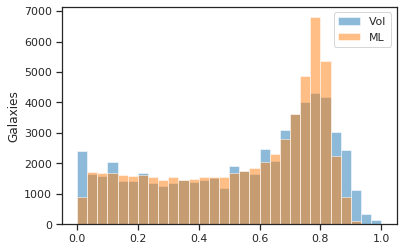

In [84]:
sns.set_style('ticks')
_, bins = np.histogram(np.linspace(0., 1.), bins=30)
plt.hist(retired['smooth-or-featured_smooth_fraction'], alpha=.5, bins=bins, label='Vol')
plt.hist(retired['smooth-or-featured_smooth_fraction_ml'], alpha=.5, bins=bins, label='ML')
plt.ylabel('Galaxies')
plt.legend()

(0.0, 1.0)

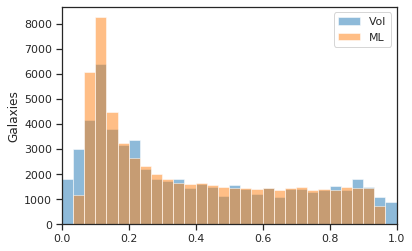

In [86]:
sns.set_style('ticks')
_, bins = np.histogram(np.linspace(0., 1.), bins=30)
plt.hist(retired['smooth-or-featured_featured-or-disk_fraction'], alpha=.5, bins=bins, label='Vol')
plt.hist(retired['smooth-or-featured_featured-or-disk_fraction_ml'], alpha=.5, bins=bins, label='ML')
plt.ylabel('Galaxies')
plt.legend()
plt.xlim([0., 1.])

Text(0, 0.5, 'ML "Smooth" fraction')

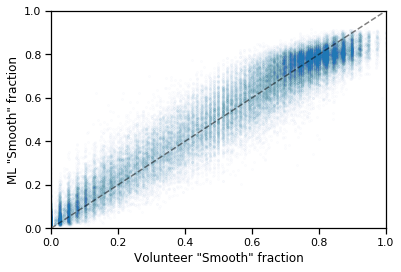

In [18]:
plt.scatter(retired['smooth-or-featured_smooth_fraction'], retired['smooth-or-featured_smooth_fraction_ml'], alpha=.01, s=5.)
plt.plot([0., 1.], [0., 1.], 'k--', alpha=.5)
plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.xlabel('Volunteer "Smooth" fraction')
plt.ylabel('ML "Smooth" fraction')

Text(0, 0.5, 'ML "Spiral" fraction')

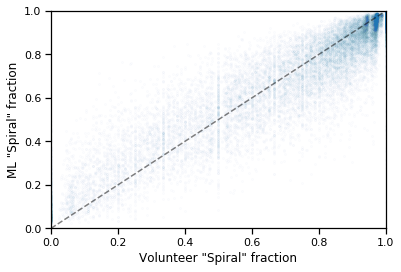

In [19]:
featured = retired[(retired['disk-edge-on_no_fraction'] > 0.5) & (retired['smooth-or-featured_smooth_fraction'] <= 0.5)]
plt.scatter(featured['has-spiral-arms_yes_fraction'], featured['has-spiral-arms_yes_fraction_ml'], alpha=.01, s=5.)
plt.plot([0., 1.], [0., 1.], 'k--', alpha=.5)
plt.xlim([0., 1.])
plt.ylim([0., 1.])
plt.xlabel('Volunteer "Spiral" fraction')
plt.ylabel('ML "Spiral" fraction')

In [20]:
retired.columns.values

array(['iauname', 'smooth-or-featured_smooth_fraction_ml',
       'smooth-or-featured_featured-or-disk_fraction_ml',
       'smooth-or-featured_artifact_fraction_ml',
       'disk-edge-on_yes_fraction_ml', 'disk-edge-on_no_fraction_ml',
       'has-spiral-arms_yes_fraction_ml',
       'has-spiral-arms_no_fraction_ml', 'bar_strong_fraction_ml',
       'bar_weak_fraction_ml', 'bar_no_fraction_ml',
       'bulge-size_dominant_fraction_ml', 'bulge-size_large_fraction_ml',
       'bulge-size_moderate_fraction_ml', 'bulge-size_small_fraction_ml',
       'bulge-size_none_fraction_ml', 'how-rounded_round_fraction_ml',
       'how-rounded_in-between_fraction_ml',
       'how-rounded_cigar-shaped_fraction_ml',
       'edge-on-bulge_boxy_fraction_ml', 'edge-on-bulge_none_fraction_ml',
       'edge-on-bulge_rounded_fraction_ml',
       'spiral-winding_tight_fraction_ml',
       'spiral-winding_medium_fraction_ml',
       'spiral-winding_loose_fraction_ml',
       'spiral-arm-count_1_fraction_ml', 

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Vols - ML "Smooth" fraction')

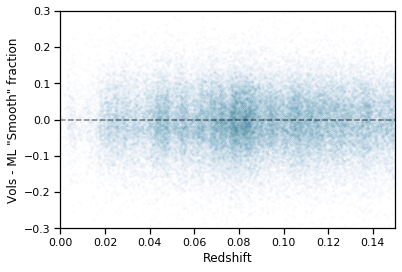

In [37]:
retired['smooth_fraction_error'] = retired['smooth-or-featured_smooth_fraction'] - retired['smooth-or-featured_smooth_fraction_ml']
plt.scatter(retired['redshift'], retired['smooth_fraction_error'], alpha=.01, s=5.)
plt.axhline(0., color='k', linestyle='--', alpha=.5)
plt.xlim([0., .15])
plt.ylim([-.3, .3])
plt.xlabel('Redshift')
plt.ylabel('Vols - ML "Smooth" fraction')

In [38]:
retired["elpetro_absmag_r_correct"] = retired["elpetro_absmag_r"]+ 5*np.log10(0.7)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [39]:
retired["elpetro_absmag_r_correct"] = retired["elpetro_absmag_r_correct"].replace(np.inf, np.nan)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


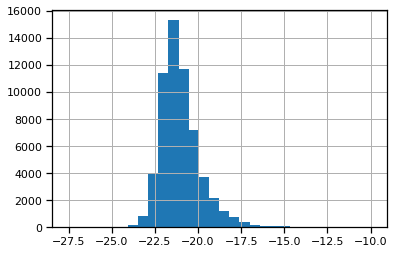

In [42]:
retired["elpetro_absmag_r_correct"].hist(bins=30)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Vols - ML "Smooth" fraction')

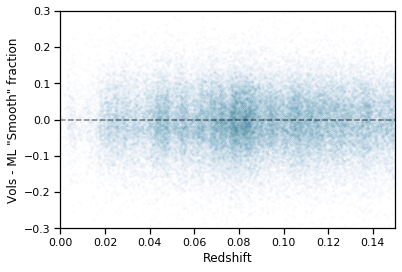

In [41]:
retired['smooth_fraction_error'] = retired['smooth-or-featured_smooth_fraction'] - retired['smooth-or-featured_smooth_fraction_ml']

plt.scatter(retired['redshift'], retired['smooth_fraction_error'], alpha=.01, s=5.)
plt.axhline(0., color='k', linestyle='--', alpha=.5)
plt.xlim([0., .15])
plt.ylim([-.3, .3])
plt.xlabel('Redshift')
plt.ylabel('Vols - ML "Smooth" fraction')

In [43]:
retired["elpetro_absmag_r_correct_0dp"] = np.around(retired["elpetro_absmag_r_correct"])

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


-18 1465
-20 9533
-22 19206
-23 2914


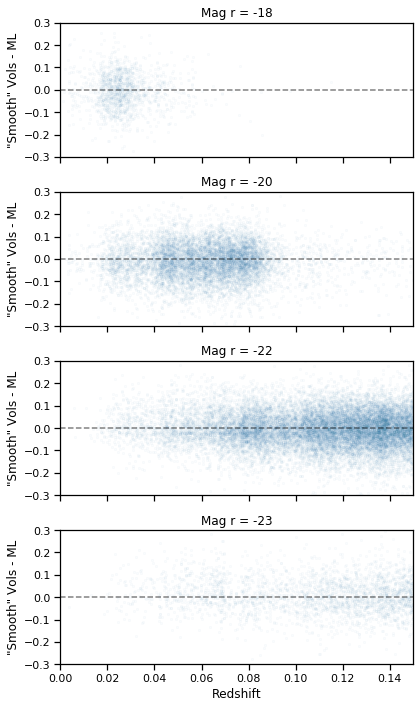

In [60]:
fig, axes = plt.subplots(nrows=4, figsize=(6, 10), sharex=True, sharey=True)
for n, mag in enumerate([-18, -20, -22, -23]):
    mag_df = retired[retired['elpetro_absmag_r_correct_0dp'] == mag]
    print(mag, len(mag_df))
    ax = axes[n]
    ax.scatter(mag_df['redshift'], mag_df['smooth_fraction_error'], alpha=.02, s=5.)
    ax.axhline(0., color='k', linestyle='--', alpha=.5)
    ax.set_xlim([0., .15])
    ax.set_ylim([-.3, .3])
    ax.set_title('Mag r = {}'.format(mag))
    ax.set_ylabel('"Smooth" Vols - ML')
ax.set_xlabel('Redshift')
fig.tight_layout()

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0, 0.5, 'Vols - ML "Winding=Tight" fraction')

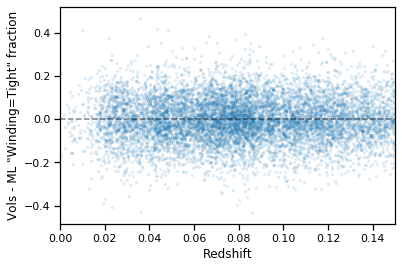

In [65]:
winding = retired[retired['spiral-winding_proportion_volunteers_asked'] > 0.5]
winding['winding_tight_fraction_error'] = winding['spiral-winding_tight_fraction'] - winding['spiral-winding_tight_fraction_ml']
plt.scatter(winding['redshift'], winding['winding_tight_fraction_error'], alpha=.1, s=5.)
plt.axhline(0., color='k', linestyle='--', alpha=.5)
plt.xlim([0., .15])
# plt.ylim([-.3, .3])
plt.xlabel('Redshift')
plt.ylabel('Vols - ML "Winding=Tight" fraction')

-18 62
-20 1134
-22 4003
-23 553


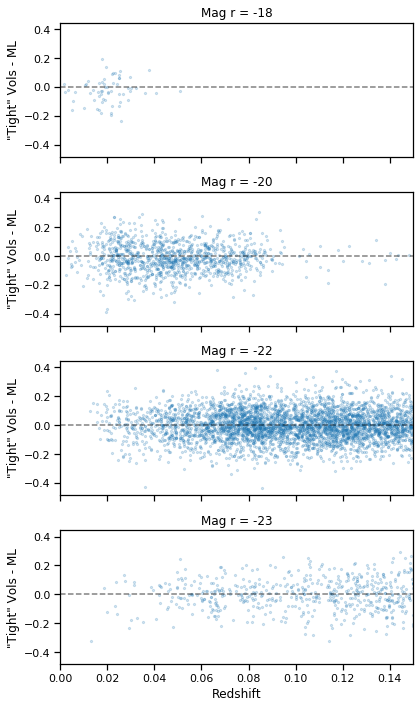

In [71]:
fig, axes = plt.subplots(nrows=4, figsize=(6, 10), sharex=True, sharey=True)
for n, mag in enumerate([-18, -20, -22, -23]):
    mag_df = winding[winding['elpetro_absmag_r_correct_0dp'] == mag]
    print(mag, len(mag_df))
    ax = axes[n]
    ax.scatter(mag_df['redshift'], mag_df['winding_tight_fraction_error'], alpha=.2, s=5.)
    ax.axhline(0., color='k', linestyle='--', alpha=.5)
    ax.set_xlim([0., .15])
#     ax.set_ylim([-.3, .3])
    ax.set_title('Mag r = {}'.format(mag))
    ax.set_ylabel('"Tight" Vols - ML')
ax.set_xlabel('Redshift')
fig.tight_layout()

In [72]:
winding.columns.values

array(['iauname', 'smooth-or-featured_smooth_fraction_ml',
       'smooth-or-featured_featured-or-disk_fraction_ml',
       'smooth-or-featured_artifact_fraction_ml',
       'disk-edge-on_yes_fraction_ml', 'disk-edge-on_no_fraction_ml',
       'has-spiral-arms_yes_fraction_ml',
       'has-spiral-arms_no_fraction_ml', 'bar_strong_fraction_ml',
       'bar_weak_fraction_ml', 'bar_no_fraction_ml',
       'bulge-size_dominant_fraction_ml', 'bulge-size_large_fraction_ml',
       'bulge-size_moderate_fraction_ml', 'bulge-size_small_fraction_ml',
       'bulge-size_none_fraction_ml', 'how-rounded_round_fraction_ml',
       'how-rounded_in-between_fraction_ml',
       'how-rounded_cigar-shaped_fraction_ml',
       'edge-on-bulge_boxy_fraction_ml', 'edge-on-bulge_none_fraction_ml',
       'edge-on-bulge_rounded_fraction_ml',
       'spiral-winding_tight_fraction_ml',
       'spiral-winding_medium_fraction_ml',
       'spiral-winding_loose_fraction_ml',
       'spiral-arm-count_1_fraction_ml', 

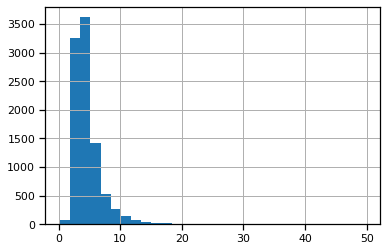

In [74]:
winding['petro_th50'].hist(bins=30)

In [76]:
winding['petro_th50_0dp'] = np.around(winding['petro_th50'], 0)

/home/walml/anaconda3/envs/zoobot/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
len(winding) / len(retired)

0.16057434652914707

2 735
3 2523
6 828
10 136


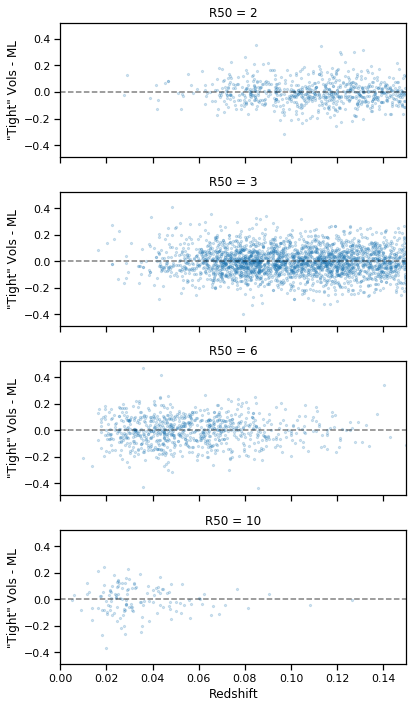

In [78]:
fig, axes = plt.subplots(nrows=4, figsize=(6, 10), sharex=True, sharey=True)
for n, mag in enumerate([2, 3, 6, 10]):
    mag_df = winding[winding['petro_th50_0dp'] == mag]
    print(mag, len(mag_df))
    ax = axes[n]
    ax.scatter(mag_df['redshift'], mag_df['winding_tight_fraction_error'], alpha=.2, s=5.)
    ax.axhline(0., color='k', linestyle='--', alpha=.5)
    ax.set_xlim([0., .15])
#     ax.set_ylim([-.3, .3])
    ax.set_title('R50 = {}'.format(mag))
    ax.set_ylabel('"Tight" Vols - ML')
ax.set_xlabel('Redshift')
fig.tight_layout()